In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
tf.config.set_visible_devices([], 'GPU')

In [2]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_70576/2378408844.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:   27.4s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   38.2s finished

[2022-04-10 14:56:12] Features: 18/10 -- score: 0.14346839784536086[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   25.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   35.3s finished

[2022-04-10 14:56:48] Features: 17/10 -- score: 0.16454809600426848[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Don

SequentialFeatureSelector(estimator=RandomForestRegressor(), forward=False,
                          k_features=10, n_jobs=-1, scoring='r2', verbose=2)

In [5]:
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_70576/1273356578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=data['Close'].shift(-1)
/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_70576/1273356578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,Open,High,Low,Close,Adj Close,Volume,%R5,%R10,EMA12,TR,Prediction
Date,,,,,,,,,,,
2022-03-30,383.000000,388.600006,380.200012,380.600006,380.600006,26951872,-21.276592,-43.726231,375.239148,11.399994,374.200012
2022-03-31,382.399994,382.399994,372.600006,374.200012,374.200012,14589554,-38.297850,-55.893518,375.079281,9.799988,378.799988
2022-04-01,367.000000,378.799988,362.200012,378.799988,378.799988,14496674,-28.323747,-47.148318,375.651697,16.599976,390.000000
2022-04-04,388.799988,391.000000,383.799988,390.000000,390.000000,15665556,-3.472224,-25.855522,377.859129,12.200012,381.000000
2022-04-06,383.000000,385.000000,380.000000,381.000000,381.000000,17127923,-34.722237,-42.965786,378.342340,10.000000,374.399994


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3843, 1, 10) (3843, 1) (427, 1, 10) (427, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_70576/2420511516.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [9]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 14:59:17.625041: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


109/109 [==============================] - 2s 7ms/step - loss: 47945.1758 - val_loss: 30755.7070
Epoch 2/300
109/109 [==============================] - 0s 2ms/step - loss: 12484.4219 - val_loss: 4060.5535
Epoch 3/300
109/109 [==============================] - 0s 2ms/step - loss: 2599.7019 - val_loss: 1764.4468
Epoch 4/300
109/109 [==============================] - 0s 2ms/step - loss: 1456.9418 - val_loss: 1018.5349
Epoch 5/300
109/109 [==============================] - 0s 2ms/step - loss: 867.0080 - val_loss: 545.1353
Epoch 6/300
109/109 [==============================] - 0s 2ms/step - loss: 473.3799 - val_loss: 262.8882
Epoch 7/300
109/109 [==============================] - 0s 2ms/step - loss: 271.6437 - val_loss: 160.0623
Epoch 8/300
109/109 [==============================] - 0s 2ms/step - loss: 190.8849 - val_loss: 113.2710
Epoch 9/300
109/109 [==============================] - 0s 2ms/step - loss: 145.7053 - val_loss: 84.0241
Epoch 10/300
109/109 [==============================] - 0

109/109 [==============================] - 0s 2ms/step - loss: 32.4455 - val_loss: 38.1787
Epoch 80/300
109/109 [==============================] - 0s 2ms/step - loss: 32.4244 - val_loss: 38.2377
Epoch 81/300
109/109 [==============================] - 0s 2ms/step - loss: 32.4037 - val_loss: 38.2967
Epoch 82/300
109/109 [==============================] - 0s 2ms/step - loss: 32.3833 - val_loss: 38.3556
Epoch 83/300
109/109 [==============================] - 0s 2ms/step - loss: 32.3634 - val_loss: 38.4143
Epoch 84/300
109/109 [==============================] - 0s 2ms/step - loss: 32.3438 - val_loss: 38.4729
Epoch 85/300
109/109 [==============================] - 0s 2ms/step - loss: 32.3246 - val_loss: 38.5313
Epoch 86/300
109/109 [==============================] - 0s 2ms/step - loss: 32.3057 - val_loss: 38.5894
Epoch 87/300
109/109 [==============================] - 0s 2ms/step - loss: 32.2872 - val_loss: 38.6473
Epoch 88/300
109/109 [==============================] - 0s 2ms/step - loss: 3

109/109 [==============================] - 0s 2ms/step - loss: 31.4197 - val_loss: 41.8610
Epoch 158/300
109/109 [==============================] - 0s 3ms/step - loss: 31.4103 - val_loss: 41.8954
Epoch 159/300
109/109 [==============================] - 0s 2ms/step - loss: 31.4009 - val_loss: 41.9294
Epoch 160/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3916 - val_loss: 41.9631
Epoch 161/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3822 - val_loss: 41.9966
Epoch 162/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3730 - val_loss: 42.0299
Epoch 163/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3637 - val_loss: 42.0628
Epoch 164/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3545 - val_loss: 42.0955
Epoch 165/300
109/109 [==============================] - 0s 2ms/step - loss: 31.3453 - val_loss: 42.1279
Epoch 166/300
109/109 [==============================] - 0s 2ms/step 

109/109 [==============================] - 0s 2ms/step - loss: 30.6943 - val_loss: 44.1255
Epoch 236/300
109/109 [==============================] - 0s 2ms/step - loss: 30.6838 - val_loss: 44.1517
Epoch 237/300
109/109 [==============================] - 0s 2ms/step - loss: 30.6732 - val_loss: 44.1775
Epoch 238/300
109/109 [==============================] - 0s 2ms/step - loss: 30.6626 - val_loss: 44.2032
Epoch 239/300
109/109 [==============================] - 0s 2ms/step - loss: 30.6520 - val_loss: 44.2285
Epoch 240/300
109/109 [==============================] - 0s 3ms/step - loss: 30.6413 - val_loss: 44.2537
Epoch 241/300
109/109 [==============================] - 0s 2ms/step - loss: 30.6307 - val_loss: 44.2786
Epoch 242/300
109/109 [==============================] - 0s 3ms/step - loss: 30.6200 - val_loss: 44.3032
Epoch 243/300
109/109 [==============================] - 0s 3ms/step - loss: 30.6093 - val_loss: 44.3276
Epoch 244/300
109/109 [==============================] - 0s 3ms/step 

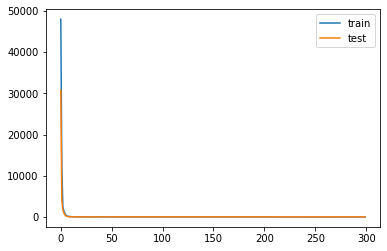

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

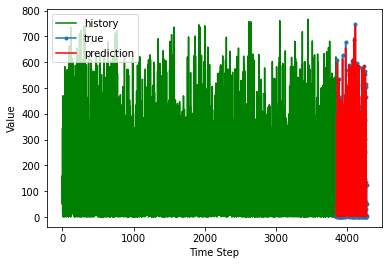

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

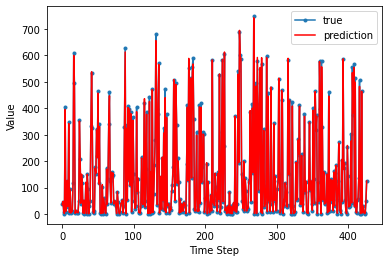

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.9989114765032886

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.1121514057530589

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

5.936023960841288

In [16]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_70576/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


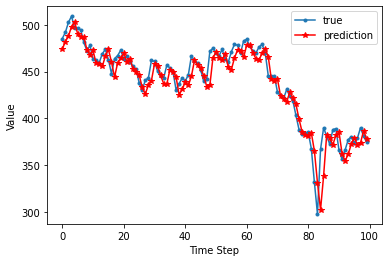

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.889858081756736

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.023396705358249194

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

13.975411506123649